_____
# Deep Neural Network
_____

## Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

_______
## Activation Functions

In [2]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    
    A = np.maximum(0,Z)
    
    cache = Z 
    return A, cache

## Gradients for Activation Functions

In [3]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

________________________
 ## Initializing Parameters
 
- #### For 2 Layer Neural Network

In [4]:
def initialize_parameters(n_x, n_h, n_y):
    """
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    """
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

- #### For N Layer Neural Network

In [5]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

______
## Forward propagation module

###  Linear Forward 

The linear forward module computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$



In [6]:
def linear_forward(A, W, b):
    """
    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

## With Activation Function

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    
    return A, cache

## For L Layers

In [8]:
def L_model_forward(X, parameters):
    """
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation="relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],activation="sigmoid")
    caches.append(cache)
            
    return AL, caches

_______
## Cost function

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$


In [9]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    cost = (-1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

______
## Backward Propogation

In [10]:
def linear_backward(dZ, cache):
    """
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [11]:
def linear_activation_backward(dA, cache, activation):
    """
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [12]:
def L_model_backward(AL, Y, caches):
    """
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

______
## Update Parameters


$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

- where $\alpha$ is the learning rate. 

In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W"+str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)]-learning_rate*grads["db"+str(l+1)]
        
    return parameters

_____
## Predictions on the data

In [14]:
def predict(X, y, parameters):
    """
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

__________
# Importing the dataset

## Titanic Dataset

In [15]:
titanic = pd.read_csv('titanic_train.csv')

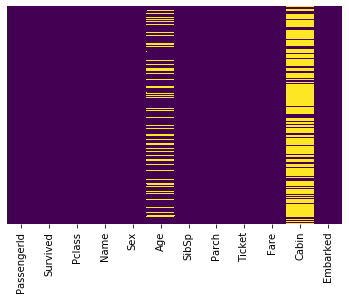

In [16]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Cleaning the data

In [17]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [18]:
titanic['Age'] = titanic[['Age','Pclass']].apply(impute_age,axis=1)

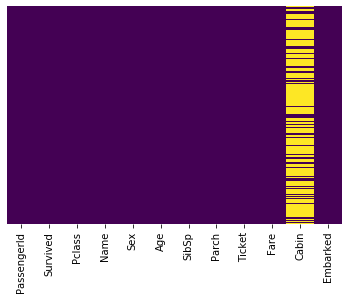

In [19]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [20]:
titanic.drop('Cabin',axis=1,inplace=True)

In [21]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Inserting Dummy Variables

In [22]:
sex = pd.get_dummies(titanic['Sex'],drop_first=True)
embark = pd.get_dummies(titanic['Embarked'],drop_first=True)

In [23]:
titanic.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [24]:
titanic = pd.concat([titanic,sex,embark],axis=1)

In [25]:
titanic.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [26]:
titanic_x=titanic.drop(['S'],axis=1)

In [27]:
titanic_y=titanic.drop(['PassengerId','Survived','Pclass','Age','SibSp','Parch','Fare','male','Q'],axis=1)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(titanic_x, 
                                                    titanic_y, test_size=0.30)

In [30]:
X_train=X_train.to_numpy().T
X_test=X_test.to_numpy().T
y_train=y_train.to_numpy().T
y_test=y_test.to_numpy().T

_______
# 2 - Layer Neural Network
_______

### Initialize the number of units in all the layers

In [31]:
m=len(X_train)

In [32]:
n_x = m     
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [33]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x ,n_h ,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X,W1,b1,activation="relu")
        A2, cache2 = linear_activation_forward(A1,W2,b2,activation="sigmoid")
        # cache1=X,W1,b1,Z1
        #cache2=A1,W2,b2,Z2
        ### END CODE HERE ###
        
        cost = compute_cost(A2,Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2,cache2,activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1,cache1,activation="relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## Training the model

In [34]:
#parameters = two_layer_model(X_train, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

_____
## Predictions

In [35]:
#predictions_train = predict(X_train, y_train, parameters)

In [36]:
#predictions_test = predict(X_test, y_test, parameters)

________
# L - Layer Deep Neural Network
________
- initializing the number of units in all the layers

In [37]:
m=len(X_train)

In [38]:
layers_dimsL = [m, 20, 7, 5, 1] #  4-layer model

In [39]:
layers_dimsL

[9, 20, 7, 5, 1]

In [40]:
def L_layer_model(X, Y, layers_dimsL, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    cache1=X,W1,b1,Z1
    cache2=A1,W2,b2,Z2
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dimsL)

    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X,parameters)

        
        # Compute cost.
        cost = compute_cost(AL,Y)

        # Backward propagation.
        grads = L_model_backward(AL,Y,caches)
 
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## Training the model

Cost after iteration 0: 0.643869
Cost after iteration 100: 0.601657
Cost after iteration 200: 0.597366
Cost after iteration 300: 0.595718
Cost after iteration 400: 0.593795
Cost after iteration 500: 0.587718
Cost after iteration 600: 0.587197
Cost after iteration 700: 0.591025
Cost after iteration 800: 0.583643
Cost after iteration 900: 0.585924
Cost after iteration 1000: 0.581569
Cost after iteration 1100: 0.588036
Cost after iteration 1200: 0.586024
Cost after iteration 1300: 0.581382
Cost after iteration 1400: 0.579127
Cost after iteration 1500: 0.578648
Cost after iteration 1600: 0.579359
Cost after iteration 1700: 0.582284
Cost after iteration 1800: 0.583233
Cost after iteration 1900: 0.578975
Cost after iteration 2000: 0.582459
Cost after iteration 2100: 0.576732
Cost after iteration 2200: 0.580352
Cost after iteration 2300: 0.575682
Cost after iteration 2400: 0.579356


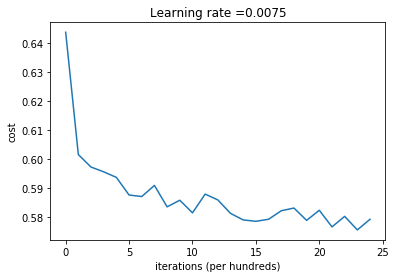

In [41]:
parameters = L_layer_model(X_train, y_train, layers_dims, num_iterations = 2500, print_cost = True)

## Predictions

In [42]:
predictions_train = predict(X_train, y_train, parameters)

Accuracy: 0.7303370786516854


In [43]:
predictions_test = predict(X_test, y_test, parameters)

Accuracy: 0.7052238805970149
